In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # konverzia na tensor [0,1]
    transforms.Normalize((0.5,), (0.5,))  # normalizácia
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


In [3]:
sample = next(iter(train_loader))
print(sample[0].shape,sample[0].min(),sample[0].max())

torch.Size([64, 1, 28, 28]) tensor(-1.) tensor(1.)


In [9]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))  # learnable scale per feature

    def forward(self, x):
        # x: [batch, embed_dim]
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return (x / rms) * self.scale  # elementwise scale

In [10]:
class Model(nn.Module):
    def __init__(self, in_dim=28*28, embed_dim=384, num_classes=10):
        super().__init__()
        self.embedding = nn.Linear(in_dim, embed_dim)   # patch embedding
        self.norm = RMSNorm(embed_dim)                  # RMS normalization
        self.wipeout = nn.Linear(embed_dim, num_classes, bias=False)  # wipeout

    def forward(self, x):
        # x shape: [batch, 1, 28, 28]
        x = x.view(x.size(0), -1)        # sploští obraz: [batch, 784]
        x = self.embedding(x)            # [batch, 384]
        x = self.norm(x)                 # RMS norm
        return self.wipeout(x)           # [batch, 10]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
model = Model().to(device)

In [14]:
print("🧩 Trainable parameters by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        print(f"{name:25s} : {num_params:,}")
        total_params += num_params

print(f"\n🔢 Total trainable parameters: {total_params:,}\n")

🧩 Trainable parameters by layer:
embedding.weight          : 301,056
embedding.bias            : 384
norm.scale                : 384
wipeout.weight            : 3,840
wipeout.bias              : 10

🔢 Total trainable parameters: 305,674



In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# training
epoch = 0

def train(num_epochs):
    global epoch
    for _ in range(num_epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
        epoch += 1

In [ ]:
num_epochs = 100
train(num_epochs)

In [34]:
# Save model and weights
classifier_name = 'mnist2vec.pth'

def save():
    torch.save(model.state_dict(), classifier_name) # weights only
    print('Saved trained model at %s ' % classifier_name)

save()

Saved trained model at mnist2vec.pth 


In [35]:
# download model
from google.colab import files
files.download(classifier_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# instead of trainig, we can download its result
#!wget http://agentspace.org/download/mnist2vec.pth
#model.load_state_dict(torch.load("mnist2vec.pth", map_location=torch.device(device)))

Epoch 78, Loss: 0.1480
Epoch 79, Loss: 0.1475
Epoch 80, Loss: 0.1465
Epoch 81, Loss: 0.1458
Epoch 82, Loss: 0.1461
Epoch 83, Loss: 0.1437
Epoch 84, Loss: 0.1444
Epoch 85, Loss: 0.1440
Epoch 86, Loss: 0.1436
Epoch 87, Loss: 0.1436


In [28]:
# evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 94.49%


In [29]:
# get few samples
test_iter = iter(test_loader)
x_sample, _ = next(test_iter)
print(x_sample.shape)

torch.Size([64, 1, 28, 28])


In [30]:
# use the model on the samples
input_images = x_sample[0:100].to(device)
output_probabilities = model(input_images).to('cpu')
output_categories = [ category.item() for category in torch.argmax(output_probabilities, dim=1) ]
print(output_categories)

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]


IndexError: index 64 is out of bounds for dimension 0 with size 64

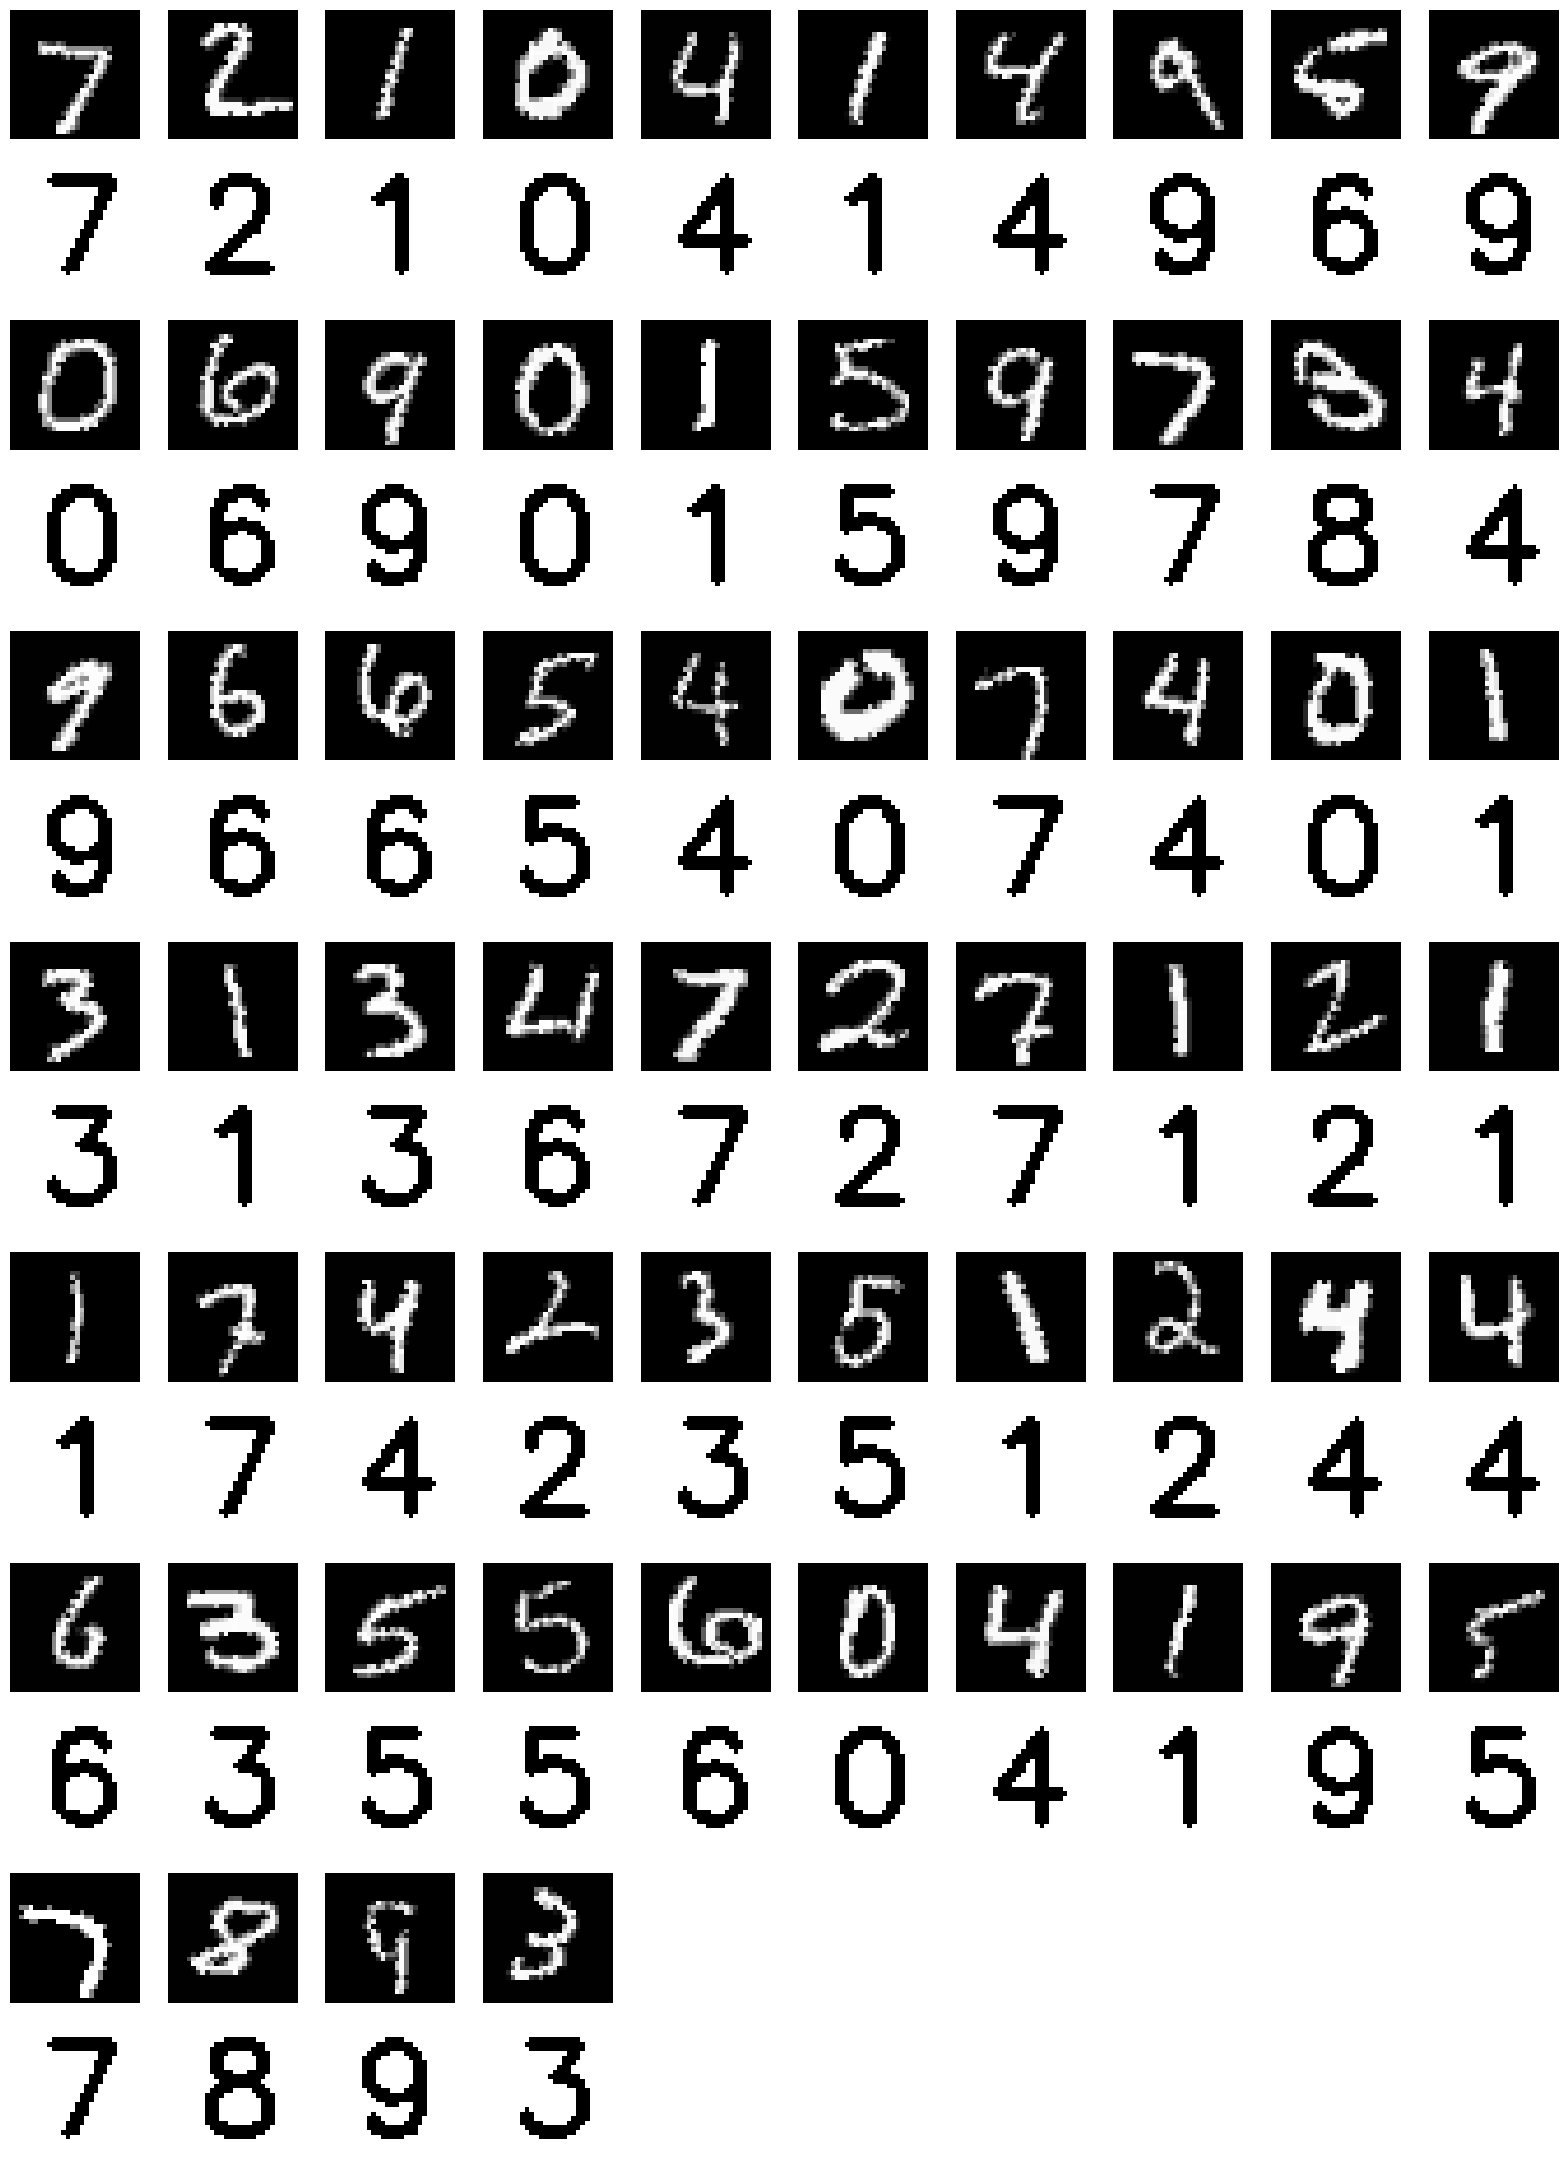

In [31]:
# show results
def render(digit):
    img = np.zeros((28, 28), dtype=np.uint8)
    cv2.putText(img, str(digit), (6, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 255, 2)
    return img

plt.figure(figsize=(20, 40))
for b in range(10):
    for i in range(10):
        input_img = (x_sample[10*b+i].squeeze(0).detach().numpy()*255).astype(np.uint8)
        plt.subplot(20, 10, 20*b+i+1)
        plt.imshow(input_img, cmap='gray')
        plt.axis('off')
        output_img = render(output_categories[10*b+i])
        plt.subplot(20, 10, 20*b+i+1+10)
        plt.imshow(~output_img, cmap='gray')
        plt.axis('off')

plt.show()

In [40]:
# back projection
def backproject_to_image(model):
    with torch.no_grad():
        We = model.embedding.weight.detach().cpu()     # [384, 784]
        Wb = model.embedding.bias.detach().cpu()       # [384]
        Wc = model.wipeout.weight.detach().cpu()    # [10, 384]
        scale = model.norm.scale.detach().cpu()        # [384]

        # pseudo-inverse of embedding
        We_pinv = torch.linalg.pinv(We)  # [784, 384]

        imgs = []
        for k in range(10):
            proto = (Wc[k] / scale)  # inverse RMSNorm scaling
            x_recon = We_pinv @ (proto-Wb)  # least squares inverse
            img = x_recon.view(28, 28)
            imgs.append(img)

        imgs = torch.stack(imgs)
    return imgs

# Get 10 reconstructed "digit prototypes"
proto_imgs = backproject_to_image(model)

In [41]:
proto_imgs.shape, proto_imgs.min(), proto_imgs.max()

(torch.Size([10, 28, 28]), tensor(-296.0424), tensor(295.3748))

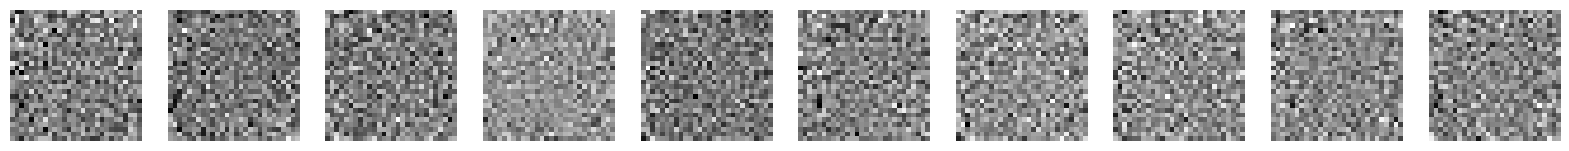

In [42]:
# show prototypes
plt.figure(figsize=(20, 40))
for i in range(10):
    mn = proto_imgs[i].min()
    mx = proto_imgs[i].max()
    input_img = (((proto_imgs[i]-mn)/(mx-mn)).cpu().detach().numpy()*255).astype(np.uint8)
    plt.subplot(1, 10, i+1)
    plt.imshow(input_img, cmap='gray')
    plt.axis('off')

plt.show()